# 总结

将RSRS指标构造融入收益率波动的信息，使得指标值能达到在震荡市场上钝化的效果，从而减少策略在震荡期间的误判次数。实证结果表明，钝化RSRS 指标 能提高各宽基指数的择时效果，使得择时策略在全样本与近年均有较好表现。在中证 500 与创业板指上，将样本点加权与钝化操作结合的成交额加权回归钝化RSRS 指标效果更佳。

# RSRS指标新的构建方式

通过改变指标本身表达形式而非回归方法，以改变RSRS择时指标。

先看原始RSRS择时指标的表达形式:

$RSRS=z\_score(\hat{\beta})*R^{2}$

其中，计算标准分$z\_score(\hat{\beta})$所用的周期为M。而这里我们在乘$R^2$的原因是当回归结果的$R^2$较小时，说明回归模型的解释力度较弱，此时标准分乘以$R^2$后数值会被往零点的方向压缩，由于策略仅在指标值绝对值大于一定阈值 后才会发出，因而指标值实际上在此时是被钝化了。

延续这个思路，既然我们观察到RSRS择时策略最近在震荡市内表现不 够稳定，那么在市场没有明确趋势的时候让指标值钝化能不能减小指标误判 的风险，从而提升指标的择时效果呢？考虑到收益率的波动率往往能够一定程度上体现市场当前的震荡水平，我们对RSRS 择时指标做出如下调整：

$RSRS=z\_score(\hat{\beta})*R^{4*quantile(std(return),M)}$

其中，quantile(std(return),M)表示当前市场收益率波动在过去M日的历史动率中所处的分位数大小。由于𝑅大于0小于 1，当分位数越大时，震荡水平越高，此时 RSRS 指标将得到更大的钝化效果。

为了方便区分新的RSRS指标与原始的RSRS指标，我们将新的指标命名为钝化RSRS指标。

计算收益率标准差的分位数中需要两个参数，一个是用最近多少天的收 益率数据来计算标准差，一个是用多少个标准差数据来计算分位数。为了尽量与$z\_score(\hat{\beta})$在信息来源上保持一致，这两个参数的值即选用与$z\_score(\hat{\beta})$时一样的N与M。


使用下面函数获取quantile(std(return),M)
```
def _cal_ret_quantile(self) -> np.array:

        # 计算收益波动
        ret_std = self.price_df['ret'].rolling(self.N).std()
        ret_quantile = ret_std.rolling(self.M).apply(
            lambda x: x.rank(pct=True)[-1], raw=False)

        return ret_quantile.values
```

这里提供了一个RSRS的回测框架

```

hs = rsrs()
# 加载
# 信号名称列表：RSRS, 标准分RSRS, 修正标准分RSRS, 右偏修正标准分RSRS, 钝化RSRS,成交额加权钝化RSRS
hs.init_from_config(指数代码,回测开始日,回测结束日,freq={回测信号名称:(N,M),...})

# 回测
hs.backtest({回测信号名称:开仓阈值})

# 输出完整报告：净值图+风险指标数据
hs.summary()

# 单独查看净值图
hs.plot_net_value()

# 单独查看风险指标
hs.report()

```

**get_RSRS**:计算各种RSRS

_regression:计算OLS回归及WLS回归所需数据
- _cal_ols:计算ols
- _cal_wls:计算wls
    - _cal_vol_weights:计成交量权重

In [1]:
# 引入库
from jqdata import *

# 标记交易时点
import pandas as pd
import numpy as np
import scipy.stats as st # 统计库
import statsmodels.api as sm # 线性回归

from IPython.core.display import HTML
import itertools # 迭代器工具

from dateutil.parser import parse
import datetime as dt

# 画图
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.family']='serif'
#mpl.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

'''
属性中的data用于储存原始数据
_Cal_RSRS处理data _Cal_RSRS生成信号列表

'''


class RSRS(object):

    def __init__(self):

        self.symbol = ''
        self.start_date = ''
        self.end_date = ''
        self.N = ''
        self.M = ''
        self.threshold = {}
        self.freq = {}

        self.price_df = pd.DataFrame()
        self.singal_df = pd.DataFrame()
        self.position_df = pd.DataFrame()

        self.hold_mark = {}
        self.buy_mark = {}
        self.sell_mark = {}

        self.strategy_ret = pd.DataFrame()
        self.strategy_cum = pd.DataFrame()

    #==============================================================================
    #                       回测
    #==============================================================================

    # 初始加载
    def init_from_config(self, symbol, start_date, end_date, freq):

        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq

        # 获取前序时间
        self._get_pretreatment_day()
        # 检查前序时间是否足够
        self._check_pretreatment_date()

        print('Query data....')
        self.query_data
        print('Calculate...')
        self.get_singal_table
        print('Success...')
    
    # 回测
    def backtesting(self, threshold_dict: dict):
        
        
        self.threshold = threshold_dict
        self.position_df, self.hold_mark, self.buy_mark, self.sell_mark = self._get_trade_info(
            self.threshold)

        self.get_net_value()

    # 数据获取
    @property
    def query_data(self):

        # 获取前序开始日
        begin = get_trade_days(
            end_date=self.start_date, count=(self.N + self.M))[0]

        # 获取价格数据
        price_df = get_price(
            self.symbol,
            begin,
            self.end_date,
            fields=['high', 'low', 'close', 'volume', 'pre_close'],
            panel=False)

        # 计算收益率
        price_df['ret'] = price_df['close'] / price_df['pre_close'] - 1

        self.price_df = price_df

    # 获取freq中各个指标计算的参数最大前序天数
    def _get_pretreatment_day(self):
        '''
        在提取数据时获取最大的N,M作为前序日期
        变换freq的k,v变换后k=(N,M),v为需要计算的RSRS名称
        相同(N,M)的合并了不用重复提取数据
        '''

        max_day = {}  # 最大前序期
        refreq = {}  # key-(N,M) value-rsrs_name

        # 判断freq中的k的rsrs名称是否合规
        self._check_threshold_key_name(self.freq.keys())

        for k, v in self.freq.items():

            max_day[k] = sum(v)
            # 转化k,v
            if v in refreq:
                refreq[v] = [refreq[v]] + [k]
            else:
                refreq[v] = k

        max_day_name = max(max_day, key=max_day.get)

        self.N = self.freq[max_day_name][0]
        self.M = self.freq[max_day_name][1]

        self.freq = refreq  # 重置freq

    #==============================================================================
    #                   核心计算
    #==============================================================================
    @property
    def get_singal_table(self):
        
        rsrs_singal = pd.concat([
            self.get_RSRS(RSRS_NAME, NM[0], NM[1])
            for NM, RSRS_NAME in self.freq.items()
        ],axis=1)
        
        self.singal_df = rsrs_singal
    
    # 计算rsrs
    def get_RSRS(self, rsrs_name, N, M):

        price_df = self.price_df

        BETA = [np.nan] * N  # 用于储存斜率
        Rsquared = [np.nan] * N  # 储存R方

        singal_df = pd.DataFrame(index=price_df.index)  # 信号储存

        # 计算OLS相关的数据
        params = self._regression()

        # ret_quantile
        ret_quantile = self._cal_ret_quantile()

        # 获取RSRS
        # 原始RSRS
        singal_df['RSRS'] = params[0]

        # 计算标准分
        singal_df['标准分RSRS'] = (singal_df['RSRS'] -
                                singal_df['RSRS'].rolling(M).mean()
                               ) / singal_df['RSRS'].rolling(M).std()

        # 计算修正标准分
        singal_df['修正标准分RSRS'] = singal_df['标准分RSRS'] * params[1]

        # 右偏标准分
        singal_df['右偏修正标准分RSRS'] = singal_df['修正标准分RSRS'] * singal_df['RSRS']

        # 钝化RSRS
        singal_df['钝化RSRS'] = singal_df['标准分RSRS'] * params[1]**(2 *
                                                                 ret_quantile)

        # 成交量加权钝化RSRS
        ## 构建df
        passiv_df = pd.DataFrame({
            'beta': params[2],
            'rsquare': params[3]
        },
                                 index=price_df.index)

        ## 计算标准分
        passiv_z = (passiv_df['beta'] - passiv_df['beta'].rolling(M).mean()
                   ) / passiv_df['beta'].rolling(M).std()
        ## 计算成交量加权钝化RSRS
        singal_df['成交额加权钝化RSRS'] = passiv_z * passiv_df['rsquare']**(
            2 * ret_quantile)

        return singal_df.loc[self.start_date:, rsrs_name]

    # 回归
    def _regression(self) -> tuple:
        '''
        返回BETA_OLS,Rsquare_OLS,BETA_WLS,Rsquare_WLS
        '''
        N = self.N
        price_df = self.price_df

        BETA_OLS = [np.nan] * N
        Rsquare_OLS = [np.nan] * N

        BETA_WLS = [np.nan] * N
        Rsquare_WLS = [np.nan] * N

        for i in range(N, price_df.shape[0]):

            vol = price_df['volume'][i - N:i]
            x = price_df['low'][i - N:i]
            y = price_df['high'][i - N:i]

            # 计算ols的所需数据
            ols_returns = self._cal_ols(x, y)

            # 计算加权回归的所需数据
            wls_returns = self._cal_wls(x, y, vol)

            BETA_OLS.append(ols_returns[0])
            Rsquare_OLS.append(ols_returns[1])

            BETA_WLS.append(wls_returns[0])
            Rsquare_WLS.append(wls_returns[1])

        return (BETA_OLS, Rsquare_OLS, BETA_WLS, Rsquare_WLS)

    # 计算ols回归的beta,r-squared
    @staticmethod
    def _cal_ols(x: pd.Series, y: pd.Series) -> tuple:
        
        # 过滤NAN
        x = np.nan_to_num(x)  
        y = np.nan_to_num(y)
        
        X = sm.add_constant(x)
        # 计算beta
        BETA = np.linalg.lstsq(X, y, rcond=-1)[0][1]
        # 计算r-squared
        Rsquared = np.corrcoef(x, y)[1, 0]**2

        return (BETA, Rsquared)

    # 计算wls回归的beta,r-squared
    def _cal_wls(self, x: pd.Series, y: pd.Series, vol: pd.Series) -> tuple:
        
        # 过滤NAN
        x = np.nan_to_num(x)  
        y = np.nan_to_num(y)
        
        X = sm.add_constant(x)
        # 计算权重
        weights = self._get_vol_weights(vol)
        
        results = sm.WLS(y, X, weights=weights).fit()

        # 计算beta
        BETA = results.params[1]
        # 计算r-squared
        Rsquared = results.rsquared

        return (BETA, Rsquared)

    # 计算ret分位数
    def _cal_ret_quantile(self) -> np.array:

        # 计算收益波动
        ret_std = self.price_df['ret'].rolling(self.N,min_periods=1).apply(np.nanstd,raw=False)
        ret_quantile = ret_std.rolling(self.M).apply(
            lambda x: x.rank(pct=True)[-1], raw=False)

        return ret_quantile.values

    # 计算成交量权重
    @staticmethod
    def _get_vol_weights(slice_series: pd.Series) -> list:

        weights = slice_series / slice_series.sum()

        return weights.values.tolist()

    
    '''
    前序时间检查
    '''
    # 检查前序时间是否足够
    def _check_pretreatment_date(self):

        traget_date = get_trade_days(end_date=parse(self.start_date).date(),count=self.M + self.N)[0]
        INDEX_START_DATE = get_security_info(self.symbol).start_date
        
        all_trade_days = get_all_trade_days()
        # 数据最早到2005-01-01所以不能超过这个值
        MAX_TRADE_DATE = max(INDEX_START_DATE,all_trade_days[0])
        limit_date = all_trade_days[np.argwhere(all_trade_days==MAX_TRADE_DATE)+(self.M+self.N)][0][0]
       
        if (traget_date - INDEX_START_DATE).days < 0:
            raise Warning('指数起始日为%s,起始日至少为%s,前序日不足,可能导致比较RSRS信号的回测起止日期不同!' %
                          (INDEX_START_DATE,limit_date))

    # 获取净值
    def get_net_value(self) -> pd.DataFrame:

        # next_ret
        pct_chg = self.price_df['ret'].shift(-1).loc[self.start_date:]

        # reshape
        ret = np.broadcast_to(
            np.expand_dims(pct_chg, axis=1), self.position_df.shape)

        strategy_ret = ret * self.position_df

        index_name = get_security_info(self.symbol).name

        # 基准收益
        strategy_ret[index_name + '净值'] = self.price_df['ret']
        strategy_cum = (1 + strategy_ret.fillna(0)).cumprod()

        self.strategy_ret = strategy_ret
        self.strategy_cum = strategy_cum

    #==============================================================================
    #                   开仓标记
    #==============================================================================

    # 获取持仓标记,持仓时间,交易情况
    def _get_trade_info(self, threshold_dict: dict):

        self._check_threshold_key_name(threshold_dict.keys())

        # 统一threshold
        for k, v in threshold_dict.items():

            if isinstance(v, tuple) and len(v) > 1:
                pass
            else:
                threshold_dict[k] = (v, -v)

        position_df = pd.DataFrame(index=self.singal_df.index)  # 储存持仓标记
        hold_mark = {}  # 持仓时间标记
        buy_mark = {}  # 卖出标记
        sell_mark = {}

        for singal_name, threshold in threshold_dict.items():

            flag, hold_flag, buy_flag, sell_flag = self._mark_flag(
                self.singal_df, singal_name, threshold)
            position_df[singal_name] = flag
            hold_mark[singal_name] = hold_flag
            buy_mark[singal_name] = buy_flag
            sell_mark[singal_name] = sell_flag

        return (position_df, hold_mark, buy_mark, sell_mark)

    # 标记持仓和平仓
    @staticmethod
    def _mark_flag(singal_df: pd.DataFrame, singal_name: str,
                   threshold: tuple) -> tuple:
        '''
        singal_df:信号df
        singal_name:信号名称
        treshold:开平仓阈值
        ======================
        returns:
        (开平仓标记,持仓时间,买入时间,卖出时间)
        '''

        UP = threshold[0]  # 开仓阈值
        DN = threshold[1]  # 平仓阈值
        pre_singal = singal_df[singal_name].shift(1)  # 昨日信号

        
        hold_flag = []  # 持仓标记
        buy_flag = []  # 买入点
        sell_flag = []  # 卖出点
        flag = []  # 持仓为1 空仓为0

        # 信号指标大于UP时开仓，小于DN时平仓
        for tradeDate, row in singal_df.iterrows():

            #===========================
            #         持仓、平仓标记
            #===========================

            # try用于过滤flag中没有元素的情况
            try:
                # 标记买入日期
                if row[singal_name] > UP and flag[-1] == 0:

                    flag.append(1)
                    buy_flag.append(tradeDate)
                    hold_flag.append(tradeDate)

                else:

                    if flag[-1] == 1 and row[singal_name] > DN:

                        flag.append(1)
                        hold_flag.append(tradeDate)

                    # 标记卖出日期
                    elif flag[-1] == 1 and row[singal_name] <= DN:

                        flag.append(0)
                        sell_flag.append(tradeDate)

                    else:

                        flag.append(0)

            except IndexError:
                if row[singal_name] > 0.7:
                    flag.append(1)
                else:
                    flag.append(0)

        return (flag, hold_flag, buy_flag, sell_flag)  # 返回信号的list

    # 检查回测用名称
    @staticmethod
    def _check_threshold_key_name(threshold_dict_keys: list):

        singal_name = [
            'RSRS', '标准分RSRS', '修正标准分RSRS', '右偏修正标准分RSRS', '钝化RSRS',
            '成交额加权钝化RSRS'
        ]

        for k in threshold_dict_keys:
            if k not in singal_name:
                raise Warning('回测用singal_name必须在%s中' % (','.join(singal_name)))

    #==============================================================================
    #                   风险数据
    #==============================================================================

    def summary(self):

        self.plot_net_value()
        
        display(HTML(self.report().to_html()))


    # 回测报告
    def report(self):

        return pd.concat([
            self._cal_risk_indicator(col_name)
            for col_name in self.threshold.keys()
        ],
                         axis=1)

    # 获取风险指标
    def _cal_risk_indicator(self, singal_name):

        strategy_cum = self.strategy_cum[singal_name]
        strategy_ret = self.strategy_ret[singal_name]
        position_df = self.position_df[singal_name]
        hold_mark = self.hold_mark[singal_name]
        buy_mark = self.buy_mark[singal_name]
        sell_mark = self.sell_mark[singal_name]

        def format_x(x):
            return '{:.2%}'.format(x)

        summary_dic = {}

        index_name = '年华收益率,累计收益率,夏普比率,最大回撤,持仓总天数,交易次数,平均持仓天数,获利天数, \
        亏损天数,胜率(按天),平均盈利率(按天),平均亏损率(按天),平均盈亏比(按天),盈利次数,亏损次数, \
        单次最大盈利,单次最大亏损,胜率(按此),平均盈利率(按次),平均亏损率(按次),平均盈亏比(按次)'.split(',')

        # 计算年华收益率
        annual_ret = pow(strategy_cum[-1] / strategy_cum[0],
                         244 / len(strategy_cum)) - 1

        # 计算累计收益率
        cum_ret_rate = strategy_cum[-1] - 1

        # 最大回撤
        max_nv = np.maximum.accumulate(np.nan_to_num(strategy_cum))
        mdd = -np.min(strategy_cum / max_nv - 1)

        # 夏普
        sharpe_ratio = (annual_ret - 0.03) / np.nanstd(strategy_cum, ddof=1)

        # 交易次数
        trade_count = len(buy_mark)

        # 持仓总天数
        total = len(hold_mark)

        # 平均持仓天数
        mean_hold = total / trade_count

        # 获利天数
        win = np.sum(np.where(strategy_ret > 0, 1, 0))

        # 亏损天数
        lose = np.sum(np.where(strategy_ret < 0, 1, 0))

        # 胜率
        win_ratio = win / total
        # 平均盈利率（天）
        mean_win_ratio = np.sum(np.where(strategy_ret > 0, strategy_ret,
                                         0)) / win
        # 平均亏损率（天）
        mean_lose_ratio = np.sum(np.where(strategy_ret < 0, strategy_ret,
                                          0)) / lose
        # 盈亏比(天)
        win_lose = win / lose

        # 盈利次数
        temp_df = pd.DataFrame({'RETURNS': strategy_ret, 'singal': position_df})

        diff = temp_df['singal'] != temp_df['singal'].shift(1)
        temp_df['singal_MARK'] = diff.cumsum()

        cond = (temp_df['singal'] == 1)
        # 每次开仓的收益率情况
        temp_df = temp_df[cond].groupby('singal_MARK')['RETURNS'].sum()

        # 盈利次数
        win_count = np.sum(np.where(temp_df > 0, 1, 0))
        # 亏损次数
        lose_count = np.sum(np.where(temp_df < 0, 1, 0))
        # 单次最大盈利
        max_win = np.max(temp_df)
        # 单次最大亏损
        max_lose = np.min(temp_df)
        # 胜率
        win_rat = win_count / len(temp_df)
        # 平均盈利率（次）
        mean_win = np.sum(np.where(temp_df > 0, temp_df, 0)) / len(temp_df)
        # 平均亏损率（天）
        mean_lose = np.sum(np.where(temp_df < 0, temp_df, 0)) / len(temp_df)
        # 盈亏比(次)
        mean_wine_lose = win_count / lose_count

        summary_dic[singal_name] = [
            format_x(annual_ret),
            format_x(cum_ret_rate), sharpe_ratio,
            format_x(mdd), total, trade_count, mean_hold, win, lose,
            format_x(win_ratio),
            format_x(mean_win_ratio),
            format_x(mean_lose_ratio), win_lose, win_count, lose_count,
            format_x(max_win),
            format_x(max_lose),
            format_x(win_rat),
            format_x(mean_win),
            format_x(mean_lose), mean_wine_lose
        ]

        summary_df = pd.DataFrame(summary_dic, index=index_name)

        return summary_df

    # 画图
    def plot_net_value(self):

        mpl.rcParams['font.family'] = 'serif'
        plt.figure(figsize=(18, 8))
        name = get_security_info(self.symbol).display_name
        plt.title(name+'净值表现')
        sns.lineplot(data=self.strategy_cum)


我们在各指数上测试钝化 RSRS 指标的择时效果，在交易波动更易变化的中证500与创业板指上择时效果显著提升，而在大盘股指上的择时效果提升幅度较为有限。

|指数名称|钝化RSRS择时|原始RSRS择时|
|--|--|--|
|沪深300|18,700,0.7|18,600,0.7|
|上证综指|19,800,0.7|19,800,0.8|
|上证50|16,700,0.3|18,500,0.6|
|中证500|18,800,1|19,600,0.8|
|创业板|18,500,0.4|18,600,0.5|

## 沪深300

Query data....
Calculate...
Success...


,钝化RSRS,右偏修正标准分RSRS
年华收益率,10.26%,11.83%
累计收益率,214.95%,271.87%
夏普比率,0.0944526,0.0929158
最大回撤,42.97%,42.97%
持仓总天数,1425,1601
交易次数,44,36
平均持仓天数,32.3864,44.4722
获利天数,754,850
亏损天数,670,750
胜率(按天),52.91%,53.09%


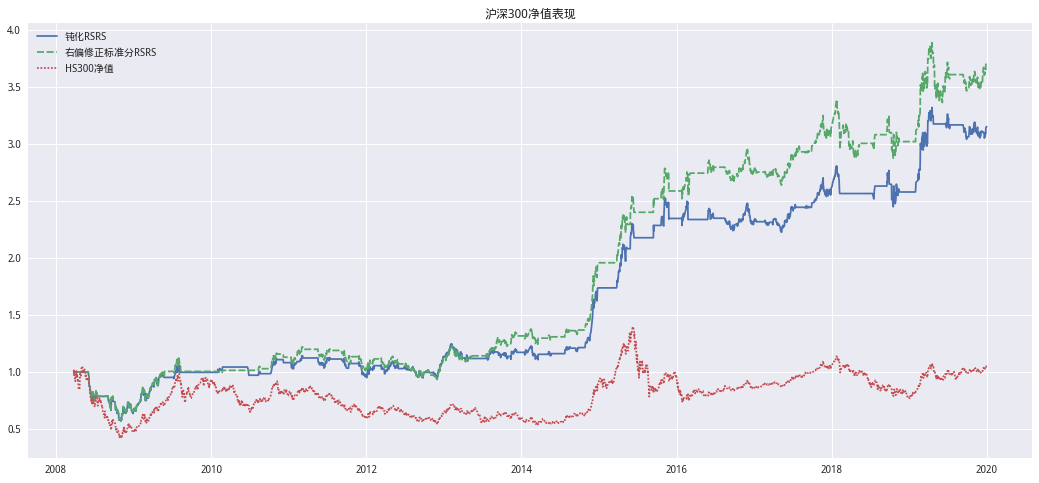

In [21]:
# 加载
hs300 = RSRS()

# 载入数据
hs300.init_from_config(
    '000300.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (18, 700),
        '右偏修正标准分RSRS': (18, 600)
    })

# 回测
hs300.backtesting({'钝化RSRS': 0.7, '右偏修正标准分RSRS': 0.7})
# 报告输出
hs300.summary()

## 上证综指

Query data....
Calculate...
Success...


,钝化RSRS,右偏修正标准分RSRS
年华收益率,12.04%,14.25%
累计收益率,280.46%,378.67%
夏普比率,0.0758018,0.0696126
最大回撤,25.71%,31.48%
持仓总天数,1293,1701
交易次数,46,30
平均持仓天数,28.1087,56.7
获利天数,699,922
亏损天数,593,778
胜率(按天),54.06%,54.20%


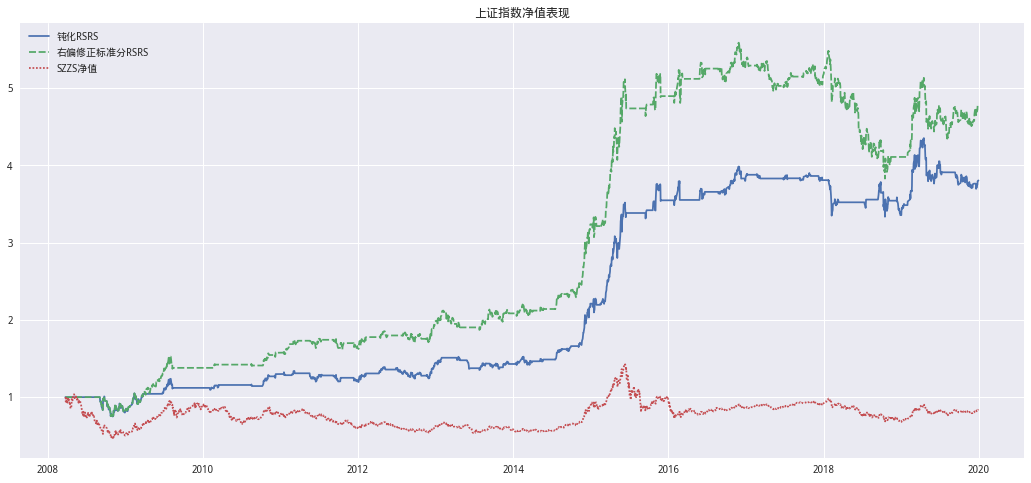

In [17]:
# 加载
S_A = RSRS()
# 载入数据
S_A.init_from_config(
    '000001.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (19, 800),
        '右偏修正标准分RSRS': (19, 800)
    })

# 回测
S_A.backtesting({'钝化RSRS': 0.7, '右偏修正标准分RSRS': 0.8})
# 报告输出
S_A.summary()

## 上证50

Query data....
Calculate...
Success...


,钝化RSRS,右偏修正标准分RSRS
年华收益率,6.32%,10.75%
累计收益率,105.39%,231.77%
夏普比率,0.0906661,0.0954478
最大回撤,36.24%,42.28%
持仓总天数,1500,1724
交易次数,83,35
平均持仓天数,18.0723,49.2571
获利天数,779,889
亏损天数,720,834
胜率(按天),51.93%,51.57%


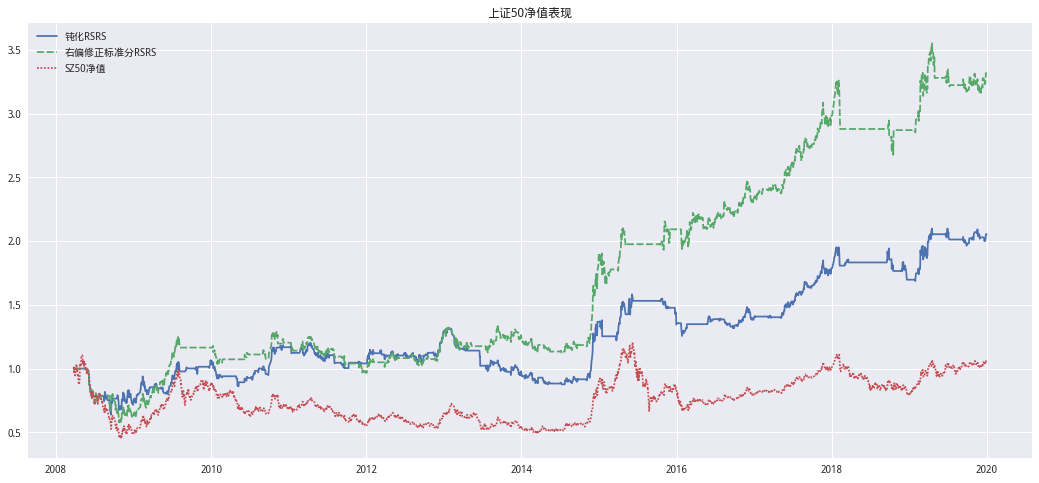

In [2]:
# 加载
sh50 = RSRS()
# 载入数据
sh50.init_from_config(
    '000016.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (16, 700),
        '右偏修正标准分RSRS': (18, 500)
    })
# 回测
sh50.backtesting({'钝化RSRS': 0.3, '右偏修正标准分RSRS': 0.6})
# 报告输出
sh50.summary()

## 中证500

Query data....
Calculate...
Success...


,钝化RSRS,右偏修正标准分RSRS
年华收益率,11.32%,5.06%
累计收益率,177.32%,59.33%
夏普比率,0.106912,0.0428371
最大回撤,35.46%,46.25%
持仓总天数,1067,1523
交易次数,21,23
平均持仓天数,50.8095,66.2174
获利天数,597,820
亏损天数,470,703
胜率(按天),55.95%,53.84%


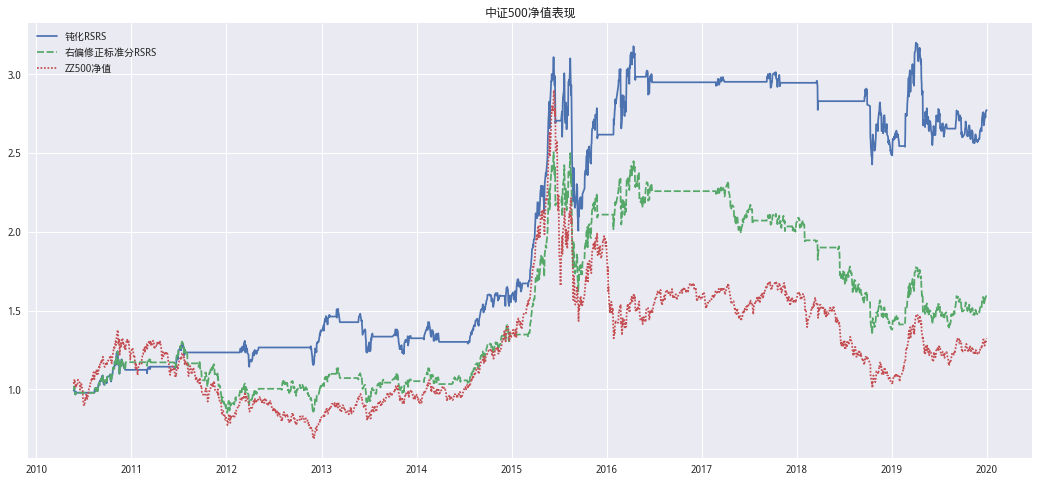

In [16]:
# 加载
zz500 = RSRS()
# 载入数据
zz500.init_from_config(
    '000905.XSHG',
    '2010-05-24',
    '2019-12-31',
    freq={
        '钝化RSRS': (18, 800),
        '右偏修正标准分RSRS': (19, 600)
    })
# 回测
zz500.backtesting({'钝化RSRS': 1, '右偏修正标准分RSRS': 0.8})
# 输出报告
zz500.summary()

## 创业版

Query data....
Calculate...
Success...


,钝化RSRS,右偏修正标准分RSRS
年华收益率,30.94%,25.71%
累计收益率,564.38%,399.05%
夏普比率,0.15137,0.162791
最大回撤,26.98%,23.11%
持仓总天数,950,945
交易次数,38,30
平均持仓天数,25,31.5
获利天数,513,503
亏损天数,436,441
胜率(按天),54.00%,53.23%


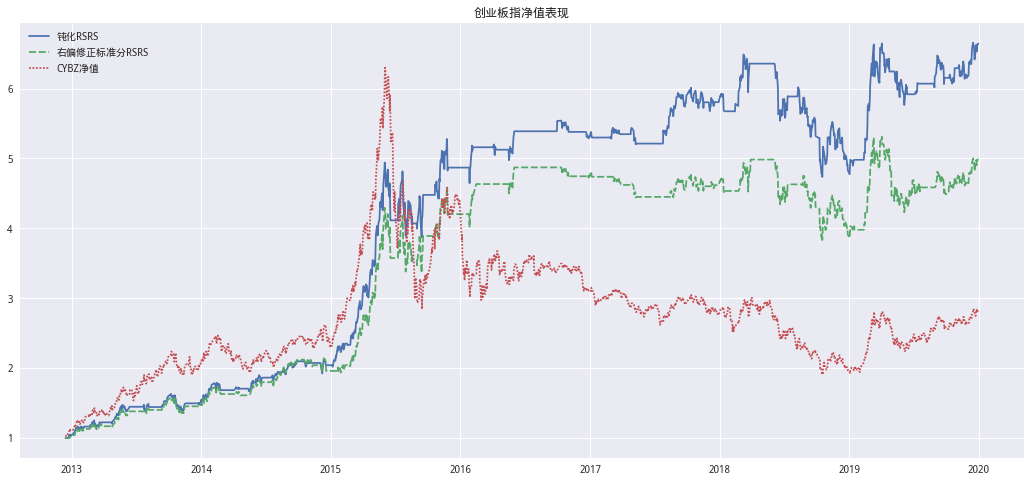

In [12]:
# 加载
cyb = RSRS()
# 载入数据
cyb.init_from_config(
    '399006.XSHE',
    '2012-12-14',
    '2019-12-31',
    freq={
        '钝化RSRS': (18, 500),
        '右偏修正标准分RSRS': (18, 600)
    })
# 回测
cyb.backtesting({'钝化RSRS': 0.4, '右偏修正标准分RSRS': 0.5})
# 输出报告
cyb.summary()

# 结合成交额加权回归与钝化方法的 RSRS 择时策略

在原始RSRS计算中，回归操作是采用简单线性回归的方式，意味着我们假设对于每一天的数据样本应当同等重视。但在真实市场上，每一日的价格信息对于当前市场情绪的影响可能并不相同，在这一部分，我们希望能够通过加权线性回归的方式改进RSRS择时模型，使得那些更能表达前市场情绪的价格信息样本点在回归中更受重视。

相较于简单线性回归的目标函数：

$\min\limits_{\beta}\sum^{N}_{i=1}(Y_i-\beta^{T}X_i)^2$

加权线性回归通过在每一个样本点加入权重$W_𝑖$的方式来重新构建目标函数：

$\min\limits_{\beta}\sum^{N}_{i=1}w_{i}(Y_i-\beta^{T}X_i)^2$

我们考虑采用每日成交额来给交易日赋予不同的权重，其逻辑在 于参与的交易越多，当天的价格数据融入的信息交换就越充分，其最低价最 高价对于市场对阻力跟支撑的表征能力就越强。在回归中其具体权重设置为
令每个数据点的权重等于当日成交额除以回归样本内𝑁日的总成交额。

其代码实现:
```
# 计算wls回归的beta,r-squared
    def _cal_wls(self, x: pd.Series, y: pd.Series, vol: pd.Series) -> tuple:
        
        # 过滤NAN
        x = np.nan_to_num(x)  
        y = np.nan_to_num(y)
        
        X = sm.add_constant(x)
        # 计算权重
        weights = self._get_vol_weights(vol)
        
        results = sm.WLS(y, X, weights=weights).fit()

        # 计算beta
        BETA = results.params[1]
        # 计算r-squared
        Rsquared = results.rsquared

        return (BETA, Rsquared)
        
   # 计算成交量权重
    @staticmethod
    def _get_vol_weights(slice_series: pd.Series) -> list:

        weights = slice_series / slice_series.sum()

        return weights.values.tolist()

```

|指数名称|钝化RSRS择时|原始RSRS择时|
|--|--|--|
|沪深300|19,500,0.8|18,600,0.7|
|上证综指|15,800,0.5|19,800,0.8|
|上证50|15,700,0.8|18,500,0.6|
|中证500|15,700,0.6|19,600,0.8|
|创业板|20,400,0.3|18,600,0.5|

## 沪深300

Query data....
Calculate...
Success...


,钝化RSRS,成交额加权钝化RSRS,右偏修正标准分RSRS
年华收益率,10.26%,11.69%,11.83%
累计收益率,214.95%,266.64%,271.87%
夏普比率,0.0944526,0.0866042,0.0929158
最大回撤,42.97%,42.97%,42.97%
持仓总天数,1425,1541,1601
交易次数,44,40,36
平均持仓天数,32.3864,38.525,44.4722
获利天数,754,816,850
亏损天数,670,724,750
胜率(按天),52.91%,52.95%,53.09%


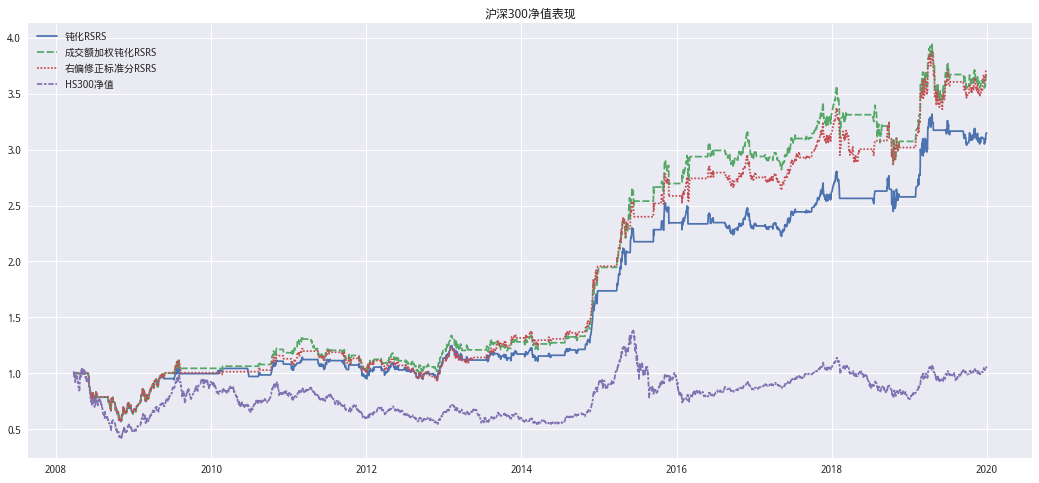

In [21]:
# 加载
hs300 = RSRS()

# 载入数据
hs300.init_from_config(
    '000300.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (18, 700),
        '成交额加权钝化RSRS': (19, 500),
        '右偏修正标准分RSRS': (18, 600)
    })

# 回测
hs300.backtesting({'钝化RSRS': 0.7, 
                   '成交额加权钝化RSRS': 0.8, 
                   '右偏修正标准分RSRS': 0.7})
# 报告输出
hs300.summary()

## 上证综指

Query data....
Calculate...
Success...


,钝化RSRS,成交额加权钝化RSRS,右偏修正标准分RSRS
年华收益率,12.04%,8.79%,14.25%
累计收益率,280.46%,169.15%,378.67%
夏普比率,0.0758018,0.0703068,0.0696126
最大回撤,25.71%,39.80%,31.48%
持仓总天数,1293,1380,1701
交易次数,46,61,30
平均持仓天数,28.1087,22.623,56.7
获利天数,699,734,922
亏损天数,593,645,778
胜率(按天),54.06%,53.19%,54.20%


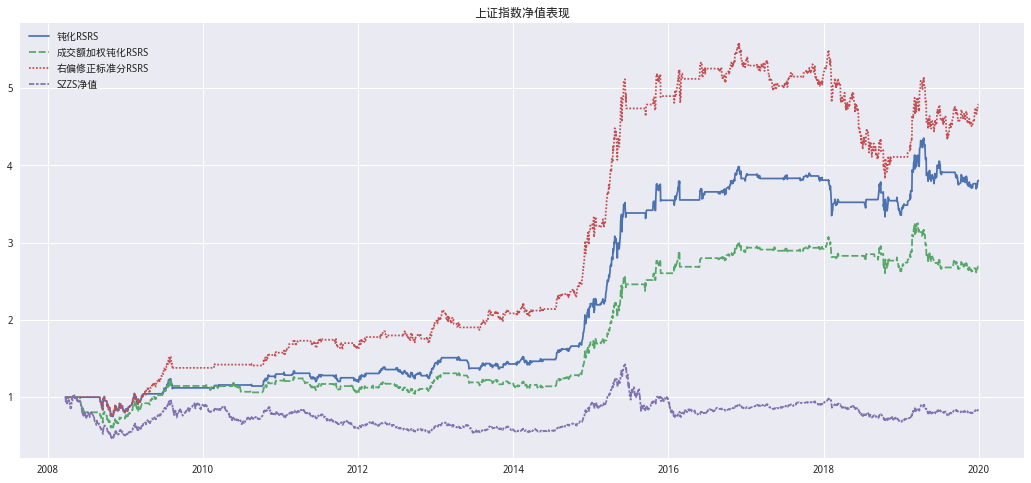

In [22]:
# 加载
S_A = RSRS()

# 载入数据
S_A.init_from_config(
    '000001.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (19, 800),
        '成交额加权钝化RSRS': (15, 800),
        '右偏修正标准分RSRS': (19, 800)
    })

# 回测
S_A.backtesting({'钝化RSRS': 0.7,
                 '成交额加权钝化RSRS': 0.5,
                 '右偏修正标准分RSRS': 0.8})
# 报告输出
S_A.summary()

## 上证50

Query data....
Calculate...
Success...


,钝化RSRS,成交额加权钝化RSRS,右偏修正标准分RSRS
年华收益率,6.32%,9.02%,10.75%
累计收益率,105.39%,175.85%,231.77%
夏普比率,0.0906661,0.115567,0.0954478
最大回撤,36.24%,28.18%,42.28%
持仓总天数,1500,1637,1724
交易次数,83,37,35
平均持仓天数,18.0723,44.2432,49.2571
获利天数,779,851,889
亏损天数,720,785,834
胜率(按天),51.93%,51.99%,51.57%


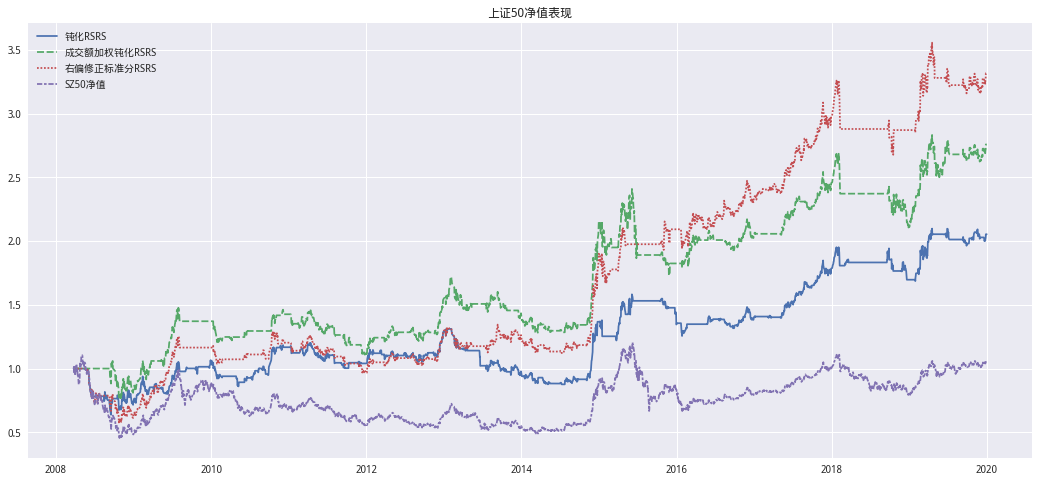

In [23]:
# 加载
sh50 = RSRS()

# 载入数据
sh50.init_from_config(
    '000016.XSHG',
    '2008-03-25',
    '2019-12-31',
    freq={
        '钝化RSRS': (16,700),
        '成交额加权钝化RSRS': (15, 500),
        '右偏修正标准分RSRS': (18, 500)
    })

# 回测
sh50.backtesting({'钝化RSRS': 0.3,
                  '成交额加权钝化RSRS': 0.8,
                  '右偏修正标准分RSRS': 0.6})
# 报告输出
sh50.summary()

## 中证500

Query data....
Calculate...
Success...


,钝化RSRS,成交额加权钝化RSRS,右偏修正标准分RSRS
年华收益率,11.32%,12.28%,5.06%
累计收益率,177.32%,201.16%,59.33%
夏普比率,0.106912,0.0916573,0.0428371
最大回撤,35.46%,29.88%,46.25%
持仓总天数,1067,1104,1523
交易次数,21,38,23
平均持仓天数,50.8095,29.0526,66.2174
获利天数,597,606,820
亏损天数,470,498,703
胜率(按天),55.95%,54.89%,53.84%


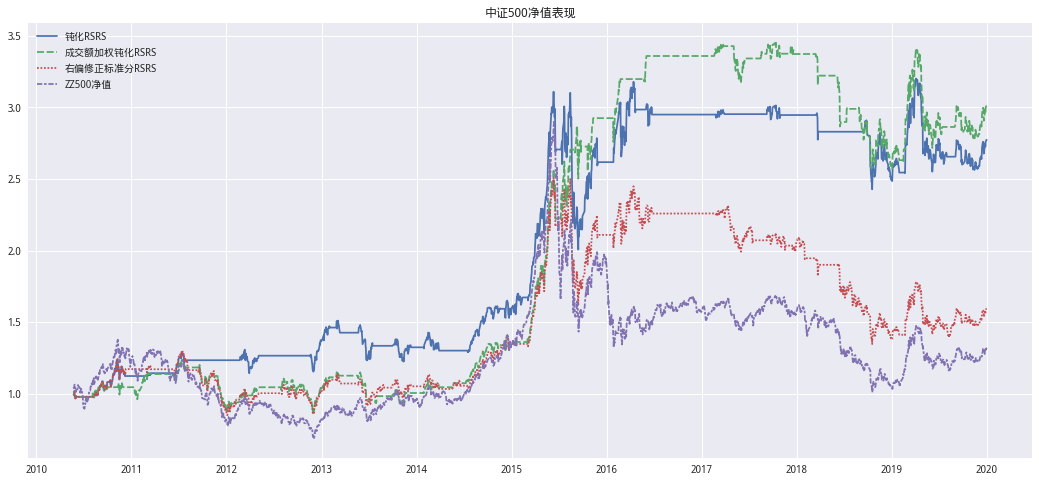

In [25]:
# 加载
zz500 = RSRS()

# 载入数据
zz500.init_from_config(
    '000905.XSHG',
    '2010-05-24',
    '2019-12-31',
    freq={
        '钝化RSRS': (18,800),
        '成交额加权钝化RSRS': (15, 700),
        '右偏修正标准分RSRS': (19, 600)
    })

# 回测
zz500.backtesting({'钝化RSRS': 1,
                   '成交额加权钝化RSRS': 0.6,
                   '右偏修正标准分RSRS': 0.8})
# 报告输出
zz500.summary()

## 创业板

Query data....
Calculate...
Success...


,钝化RSRS,成交额加权钝化RSRS,右偏修正标准分RSRS
年华收益率,16.44%,12.63%,12.91%
累计收益率,355.90%,222.38%,230.86%
夏普比率,0.108478,0.114567,0.0991544
最大回撤,30.27%,33.17%,32.60%
持仓总天数,1274,1348,1303
交易次数,54,64,46
平均持仓天数,23.5926,21.0625,28.3261
获利天数,715,748,722
亏损天数,559,600,581
胜率(按天),56.12%,55.49%,55.41%


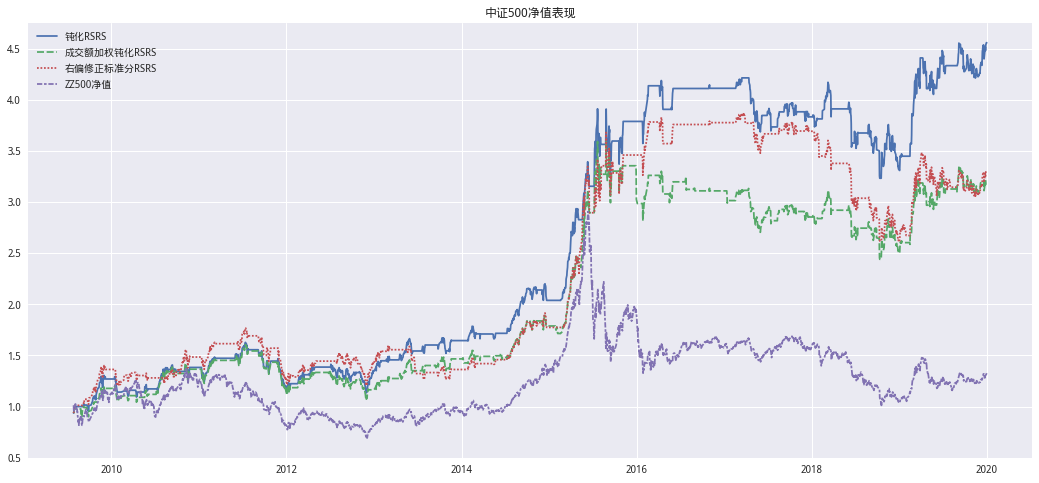

In [26]:
# 加载
cyb = RSRS()

# 载入数据
cyb.init_from_config(
    '000905.XSHG',
    '2009-07-28',
    '2019-12-31',
    freq={
        '钝化RSRS': (18,500),
        '成交额加权钝化RSRS': (20, 400),
        '右偏修正标准分RSRS': (18, 600)
    })

# 回测
cyb.backtesting({'钝化RSRS': 0.4,'成交额加权钝化RSRS': 0.3, '右偏修正标准分RSRS': 0.5})
# 报告输出
cyb.summary()